In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn import metrics

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# loading train dataset
train_csv = pd.read_csv('../input/application_train.csv.zip', compression='infer')

In [3]:
# removing 5 rows
train_csv = train_csv[train_csv['NAME_INCOME_TYPE'] != 'Maternity leave']

# removing 4 rows
train_csv = train_csv[train_csv['NAME_FAMILY_STATUS'] != 'Unknown']

# removing 2 rows
train_csv = train_csv[train_csv['CODE_GENDER'] != 'XNA']

In [4]:
# loading history data
installments = pd.read_csv('../input/installments_payments.csv.zip', compression='infer')
previous = pd.read_csv('../input/previous_application.csv.zip', compression='infer')
bureau = pd.read_csv('../input/bureau.csv.zip', compression='infer')

In [5]:
# loading balance data
credit_card_balance = pd.read_csv('../input/credit_card_balance.csv.zip', compression='infer')
#bureau_balance = pd.read_csv('../input/bureau_balance.csv.zip', compression='infer')
cash_balance = pd.read_csv('../input/POS_CASH_balance.csv.zip', compression='infer')

In [6]:
def aggregate_df(df, value, func, labels, by='SK_ID_CURR', column=None):
    
    if column != None:
        pivoted = df.pivot_table(index=by, 
                                 columns=column, 
                                 values=value, 
                                 aggfunc=func, 
                                 fill_value=0, 
                                 dropna=False)
    else:
        pivoted = df.pivot_table(index=by, 
                                 values=value, 
                                 aggfunc=func, 
                                 fill_value=0, 
                                 dropna=False)
        
    pivoted_df = pd.DataFrame(pivoted.to_records())
    
    pivoted_df.rename(columns=labels, inplace=True)
    
    return pivoted_df

In [7]:
X = train_csv
X.set_index('SK_ID_CURR',inplace=True)

In [8]:
labels = {
          'Active'   : 'CNT_ACTIVE_LOANS',
          'Bad debt' : 'CNT_BAD_DEBT',
          'Closed'   : 'CNT_CLOSED_DEBT',
          'Sold'     : 'CNT_SOLD_DEBT'
         }

cnt_loans = aggregate_df(df=bureau, value='CREDIT_TYPE', column='CREDIT_ACTIVE', func='count', labels=labels)

labels = {
          'Active'   : 'AMT_ACTIVE_LOANS',
          'Bad debt' : 'AMT_BAD_DEBT',
          'Closed'   : 'AMT_CLOSED_DEBT',
          'Sold'     : 'AMT_SOLD_DEBT'
         }

amt_loans = aggregate_df(df=bureau, value='AMT_CREDIT_SUM', column='CREDIT_ACTIVE', func='sum', labels=labels)

labels = {
          'OVERDUE'   : 'MAX_OVERDUE'
         }

installments['OVERDUE'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
max_overdue = aggregate_df(df=installments, value='OVERDUE', func='max', labels=labels)

labels = {
          'CNT_INSTALMENT_FUTURE'   : 'CNT_FUTURE_INSTALLMENTS'
         }

cnt_future_installments = aggregate_df(df=cash_balance, value='CNT_INSTALMENT_FUTURE', func='sum', labels=labels)

labels = {
          'Approved'     : 'CNT_LOANS_APPROVED',
          'Canceled'     : 'CNT_LOANS_CANCELLED',
          'Refused'      : 'CNT_LOANS_REFUSED',
          'Unused offer' : 'CNT_UNUSED_OFFERS'
         }

cnt_prev_loans = aggregate_df(df=previous, 
                              value='NAME_CONTRACT_TYPE', column='NAME_CONTRACT_STATUS', func='count', labels=labels)

labels = {
          'CNT_DRAWINGS_CURRENT'   : 'CNT_CC_DRAWINGS'
         }

cc_draw_cnt = aggregate_df(df=credit_card_balance,
                          value='CNT_DRAWINGS_CURRENT', func='sum', labels=labels)

cc_balance = pd.DataFrame(credit_card_balance.pivot_table(index='SK_ID_CURR', 
                                             values=['AMT_PAYMENT_TOTAL_CURRENT'], 
                                             columns='MONTHS_BALANCE',
                                             aggfunc='mean').to_records())[['SK_ID_CURR',"('AMT_PAYMENT_TOTAL_CURRENT', -1)"]]

cc_balance.columns = ['SK_ID_CURR', 'CREDIT_CARD_BALANCE']

X = pd.concat([X, cnt_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, amt_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, max_overdue], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cnt_future_installments], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cnt_prev_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cc_draw_cnt], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cc_balance], axis=1, join='outer', join_axes=[X.index])

del cnt_loans, amt_loans, max_overdue, cnt_future_installments, cnt_prev_loans, cc_balance, cc_draw_cnt
del previous, cash_balance, installments, bureau, credit_card_balance

In [9]:
# assigning X,y
y = X['TARGET']
X = pd.get_dummies(X.drop(['TARGET','SK_ID_CURR'], axis=1), dummy_na=True)

In [10]:
# scaled training data to be used till the end
X_Scaled = preprocessing.scale(X.fillna(-99999))

# splitting on training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_Scaled, y, test_size=0.33)

In [11]:
gboost_optimized = GradientBoostingClassifier(n_estimators=500,
                                             learning_rate=0.1,
                                             min_samples_split=15000,
                                             min_samples_leaf=1000,
                                             max_depth=5,
                                             subsample=1.0,
                                             max_features=150)

In [12]:
gboost_optimized.fit(X_Scaled, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=150, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1000, min_samples_split=15000,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [13]:
predictions = gboost_optimized.predict(X_test)
pred_prob = gboost_optimized.predict_proba(X_test)

In [14]:
print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print(roc_auc_score(y_test, pred_prob[:,1]))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     93320
          1       0.65      0.01      0.02      8155

avg / total       0.90      0.92      0.88    101475



[[93269    51]
 [ 8062    93]]


0.7607190188070136


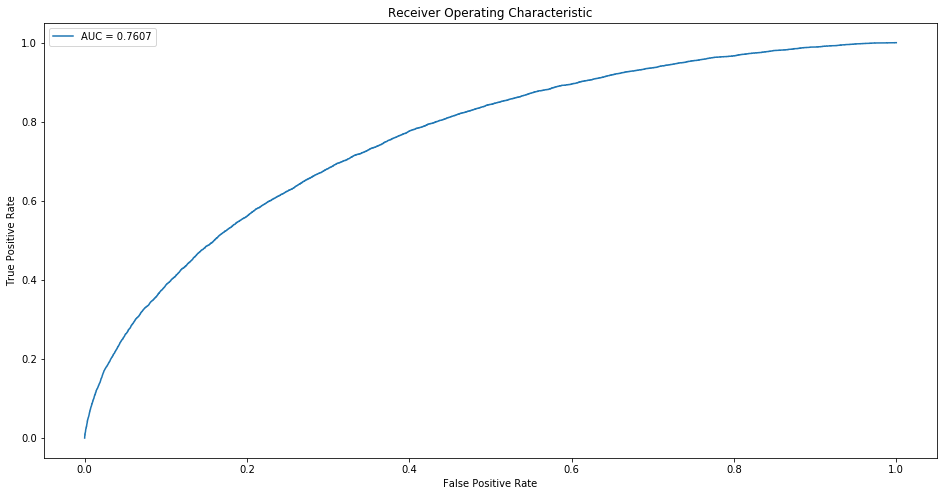

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1])
plt.figure(figsize=(16,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC = %0.4f'% roc_auc_score(y_test, pred_prob[:,1]))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='upper left')

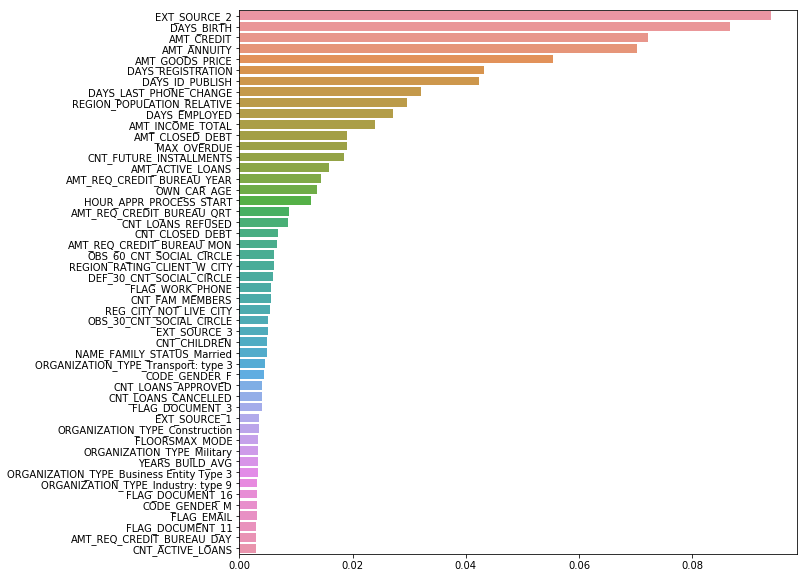

In [16]:
summary = pd.Series(gboost_optimized.feature_importances_)
summary.index = X.columns

summary.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10,10))
sns.barplot(y=summary[:50].index.values, x=summary[:50].values)

In [17]:
test_csv = pd.read_csv('../input/application_test.csv.zip', compression='infer')

In [18]:
# loading history data
installments = pd.read_csv('../input/installments_payments.csv.zip', compression='infer')
previous = pd.read_csv('../input/previous_application.csv.zip', compression='infer')
bureau = pd.read_csv('../input/bureau.csv.zip', compression='infer')

# loading balance data
credit_card_balance = pd.read_csv('../input/credit_card_balance.csv.zip', compression='infer')
#bureau_balance = pd.read_csv('../input/bureau_balance.csv.zip', compression='infer')
cash_balance = pd.read_csv('../input/POS_CASH_balance.csv.zip', compression='infer')

In [19]:
X = test_csv
X.set_index('SK_ID_CURR',inplace=True)

In [20]:
labels = {
          'Active'   : 'CNT_ACTIVE_LOANS',
          'Bad debt' : 'CNT_BAD_DEBT',
          'Closed'   : 'CNT_CLOSED_DEBT',
          'Sold'     : 'CNT_SOLD_DEBT'
         }

cnt_loans = aggregate_df(df=bureau, value='CREDIT_TYPE', column='CREDIT_ACTIVE', func='count', labels=labels)

labels = {
          'Active'   : 'AMT_ACTIVE_LOANS',
          'Bad debt' : 'AMT_BAD_DEBT',
          'Closed'   : 'AMT_CLOSED_DEBT',
          'Sold'     : 'AMT_SOLD_DEBT'
         }

amt_loans = aggregate_df(df=bureau, value='AMT_CREDIT_SUM', column='CREDIT_ACTIVE', func='sum', labels=labels)

labels = {
          'OVERDUE'   : 'MAX_OVERDUE'
         }

installments['OVERDUE'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
max_overdue = aggregate_df(df=installments, value='OVERDUE', func='max', labels=labels)

labels = {
          'CNT_INSTALMENT_FUTURE'   : 'CNT_FUTURE_INSTALLMENTS'
         }

cnt_future_installments = aggregate_df(df=cash_balance, value='CNT_INSTALMENT_FUTURE', func='sum', labels=labels)

labels = {
          'Approved'     : 'CNT_LOANS_APPROVED',
          'Canceled'     : 'CNT_LOANS_CANCELLED',
          'Refused'      : 'CNT_LOANS_REFUSED',
          'Unused offer' : 'CNT_UNUSED_OFFERS'
         }

cnt_prev_loans = aggregate_df(df=previous, 
                              value='NAME_CONTRACT_TYPE', column='NAME_CONTRACT_STATUS', func='count', labels=labels)

labels = {
          'CNT_DRAWINGS_CURRENT'   : 'CNT_CC_DRAWINGS'
         }

cc_draw_cnt = aggregate_df(df=credit_card_balance,
                          value='CNT_DRAWINGS_CURRENT', func='sum', labels=labels)

cc_balance = pd.DataFrame(credit_card_balance.pivot_table(index='SK_ID_CURR', 
                                             values=['AMT_PAYMENT_TOTAL_CURRENT'], 
                                             columns='MONTHS_BALANCE',
                                             aggfunc='mean').to_records())[['SK_ID_CURR',"('AMT_PAYMENT_TOTAL_CURRENT', -1)"]]

cc_balance.columns = ['SK_ID_CURR', 'CREDIT_CARD_BALANCE']

X = pd.concat([X, cnt_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, amt_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, max_overdue], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cnt_future_installments], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cnt_prev_loans], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cc_draw_cnt], axis=1, join='outer', join_axes=[X.index])
X = pd.concat([X, cc_balance], axis=1, join='outer', join_axes=[X.index])

del cnt_loans, amt_loans, max_overdue, cnt_future_installments, cnt_prev_loans, cc_balance, cc_draw_cnt
del previous, cash_balance, installments, bureau, credit_card_balance

In [21]:
X = pd.get_dummies(X.drop(['SK_ID_CURR'], axis=1), dummy_na=True)

In [22]:
X_Scaled = preprocessing.scale(X.fillna(-99999))

probs = gboost_optimized.predict_proba(X_Scaled)

In [23]:
submission = pd.DataFrame()
submission['TARGET'] = probs[:,1]
submission.index = test_csv.index

submission.to_csv('gboost-optimized-scaled-rev-1.csv')